In [456]:
import pandas as pd
import sweetviz as sv
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance  # ✅ Fixed import
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [457]:
# Load train and test datasets
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# Separate IDs before processing
train_ids = train["id"]
test_ids = test["id"]

# Drop the ID column from both datasets
train.drop(columns=["id"], inplace=True)
test.drop(columns=["id"], inplace=True)

In [458]:
# train.info()
# train.describe()

In [459]:
# # Generate the Sweetviz report
# report = sv.analyze(train)

# # Save the report to an HTML file
# report.show_html('sweetviz_report.html')

In [460]:
# Drop column "Edema"

# (['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
#        'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
#        'Stage', 'Drug_C', 'Drug_D-penicillamine', 'Drug_Drug', 'Drug_Placebo',
#        'Sex_F', 'Sex_M', 'Ascites_N', 'Ascites_Y', 'Hepatomegaly_N',
#        'Hepatomegaly_Y', 'Spiders_N', 'Spiders_Y', 'Edema_N', 'Edema_S',
#        'Edema_Y'],

# train.drop(columns=["Edema"], inplace=True)
# test.drop(columns=["Edema"  ], inplace=True)


In [461]:
# One-hot encode both datasets together to ensure consistent columns
train_encoded = pd.get_dummies(train)
test_encoded = pd.get_dummies(test)

# Align test set with train set to avoid missing or extra columns
train_encoded, test_encoded = train_encoded.align(test_encoded, join="left", axis=1, fill_value=0)


In [462]:
train_encoded.head()    

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y,Status_C,Status_CL,Status_D
0,193.0,18993.0,1.0,NaN,3.29,NaN,NaN,NaN,NaN,193.0,...,False,False,False,False,True,False,False,False,False,True
1,2221.0,16216.0,0.6,320.0,3.60,10.0,1282.0,122.45,80.0,358.0,...,False,True,True,False,True,False,False,True,False,False
2,625.0,25202.0,1.8,NaN,3.42,NaN,NaN,NaN,NaN,171.0,...,False,False,False,False,True,False,False,False,False,True
3,3523.0,14610.0,0.8,NaN,3.01,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,True,False,False
4,1328.0,23376.0,0.8,NaN,2.38,NaN,NaN,NaN,NaN,350.0,...,False,False,False,False,True,False,False,True,False,False


In [463]:
# Separate target variable (for training only)
X_train = train_encoded.drop(columns=["Status_C", "Status_CL", "Status_D"])  # Drop one-hot encoded status columns
y_train = train_encoded[["Status_C", "Status_CL", "Status_D"]].idxmax(axis=1).astype(str)  # Ensure it's a Series

X_test = test_encoded  # Test data has no target variable

# Ensure y_train is numerical
label_mapping = {col: i for i, col in enumerate(sorted(y_train.unique()))}  # Ensure consistent order
y_train = y_train.map(label_mapping)

X_test = test_encoded  # Test set remains unchanged

<Axes: >

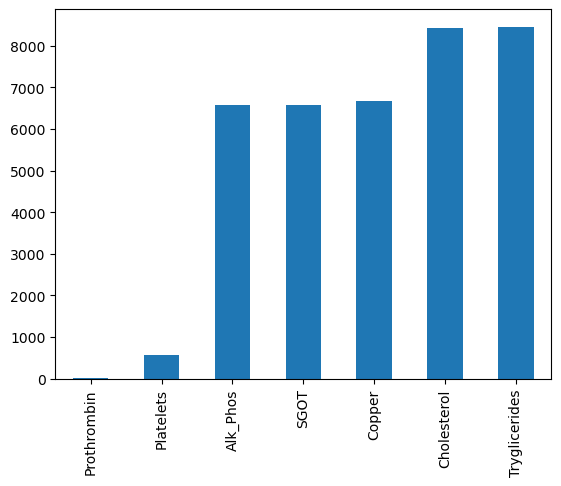

In [464]:
# summ missing
missing = X_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [465]:
# # Example: Create meaningful feature interactions
X_train["Bilirubin_Albumin_Ratio"] = X_train["Bilirubin"] / (X_train["Albumin"] + 1)
X_test["Bilirubin_Albumin_Ratio"] = X_test["Bilirubin"] / (X_test["Albumin"] + 1)

# X_train["SGOT_Albumin_Ratio"] = X_train["SGOT"] / (X_train["Albumin"] + 1)
# X_test["SGOT_Albumin_Ratio"] = X_test["SGOT"] / (X_test["Albumin"] + 1)

# X_train["Cholesterol_Triglycerides_Ratio"] = X_train["Cholesterol"] / (X_train["Tryglicerides"] + 1)
# X_test["Cholesterol_Triglycerides_Ratio"] = X_test["Cholesterol"] / (X_test["Tryglicerides"] + 1)

# X_train["Platelets_Prothrombin_Ratio"] = X_train["Platelets"] / (X_train["Prothrombin"] + 1)
# X_test["Platelets_Prothrombin_Ratio"] = X_test["Platelets"] / (X_test["Prothrombin"] + 1)

# X_train["Age_Stage_Interaction"] = X_train["Age"] * X_train["Stage"]
# X_test["Age_Stage_Interaction"] = X_test["Age"] * X_test["Stage"]

X_train["High_Bilirubin"] = (X_train["Bilirubin"] > 1.2).astype(int)  # Adjust threshold if needed
X_test["High_Bilirubin"] = (X_test["Bilirubin"] > 1.2).astype(int)

X_train["Low_Albumin"] = (X_train["Albumin"] < 3.5).astype(int)
X_test["Low_Albumin"] = (X_test["Albumin"] < 3.5).astype(int)

import numpy as np
skewed_cols = ["Bilirubin", "SGOT", "Alk_Phos", "Copper"]
for col in skewed_cols:
    X_train[col + "_log"] = np.log1p(X_train[col])
    X_test[col + "_log"] = np.log1p(X_test[col])




In [466]:
# X_train["Patient_Type"] = (X_train["Sex_M"].astype(str) + "_" +
#                            X_train["Ascites_Y"].astype(str) + "_" +
#                            X_train["Hepatomegaly_Y"].astype(str) + "_" +
#                            X_train["Spiders_Y"].astype(str) + "_" +
#                            X_train["Edema_Y"].astype(str))

# X_test["Patient_Type"] = (X_test["Sex_M"].astype(str) + "_" +
#                           X_test["Ascites_Y"].astype(str) + "_" +
#                           X_test["Hepatomegaly_Y"].astype(str) + "_" +
#                           X_test["Spiders_Y"].astype(str) + "_" +
#                           X_test["Edema_Y"].astype(str))

# # Combine unique labels from both train and test sets
# unique_labels = pd.concat([X_train["Patient_Type"], X_test["Patient_Type"]]).unique()

# # Convert to categorical encoding
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# le.fit(unique_labels)
# X_train["Patient_Type"] = le.transform(X_train["Patient_Type"])
# X_test["Patient_Type"] = le.transform(X_test["Patient_Type"])


In [467]:
# # Check feature correlation to remove redundant features
# corr_matrix = X_train.corr().abs()
# high_corr_features = corr_matrix[corr_matrix > 0.9].dropna(how='all', axis=1).columns

# high_corr_features

# # Drop highly correlated features
# X_train.drop(columns=high_corr_features, inplace=True)
# X_test.drop(columns=[col for col in high_corr_features if col in X_test], inplace=True)


In [468]:
# Mean value imputation
# train["Age"].fillna(train["Age"].mean(), inplace=True)

In [469]:
# Drop missing
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]  # Ensure y_train is aligned with X_train  # ✅ Fixed index

In [470]:
# Identify target columns from the test set
status_cols = ["Status_C", "Status_CL", "Status_D"]

# Drop any target-related columns that might be in the test set
X_test = X_test.drop(columns=[col for col in status_cols if col in X_test], errors='ignore')


In [471]:
# print shapes
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)


Shape of X_train:  (6264, 34)
Shape of X_test:  (10000, 34)
Shape of y_train:  (6264,)


In [472]:
# from sklearn.model_selection import RandomizedSearchCV
# from xgboost import XGBClassifier

# # Define hyperparameter grid
# param_grid = {
#     "max_depth": [3, 5, 7, 10],
#     "learning_rate": [0.01, 0.05, 0.1, 0.2],
#     "n_estimators": [100, 500, 1000, 2000],
#     "subsample": [0.6, 0.8, 1.0],
#     "colsample_bytree": [0.6, 0.8, 1.0],
#     "gamma": [0, 0.1, 0.3, 0.5],
#     "min_child_weight": [1, 3, 5],
#     "reg_alpha": [0, 0.1, 0.5, 1],
#     "reg_lambda": [0, 0.1, 0.5, 1],
# }

# # Initialize XGBoost model
# xgb_model = XGBClassifier(objective="multi:softprob", num_class=3, eval_metric=["mlogloss", "merror"])

# # Run randomized search
# random_search = RandomizedSearchCV(
#     xgb_model, param_grid, cv=5, n_iter=20, scoring="accuracy", n_jobs=-1, verbose=1, random_state=42
# )

# # Fit search
# random_search.fit(X_train, y_train)

# # Get best parameters
# best_params = random_search.best_params_
# print("🔥 Best Parameters Found:", best_params)

#  {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 2000,
# 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}

# # Train XGBoost with the best found parameters
# best_model = XGBClassifier(
#     objective="multi:softprob",
#     num_class=3,
#     eval_metric=['merror', "mlogloss"],
#     **best_params  # Use optimized hyperparameters
# )

# best_model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=True)

# # Predict
# y_pred_proba = best_model.predict_proba(X_test)

In [473]:

# Initialize XGBoost classifier with corrected parameters
model = XGBClassifier(
    objective='multi:softprob',  # ✅ Fixed parameter location
    num_class=3,  # ✅ Added this to match softprob
    eval_metric=["merror", "mlogloss"],  # ✅ Correctly set evaluation metrics
    n_estimators=1000,
    # early_stopping_rounds=10 
)

# Train model and evaluate on test set
model.fit(X_train, y_train, eval_set=[(X_train, y_train), ], verbose=True)  # ✅ Fixed eval_set names


[0]	validation_0-merror:0.11510	validation_0-mlogloss:0.81704
[1]	validation_0-merror:0.10983	validation_0-mlogloss:0.65179
[2]	validation_0-merror:0.10680	validation_0-mlogloss:0.54465
[3]	validation_0-merror:0.10281	validation_0-mlogloss:0.47070
[4]	validation_0-merror:0.10042	validation_0-mlogloss:0.41710
[5]	validation_0-merror:0.09850	validation_0-mlogloss:0.37533
[6]	validation_0-merror:0.09563	validation_0-mlogloss:0.34446
[7]	validation_0-merror:0.09195	validation_0-mlogloss:0.31745
[8]	validation_0-merror:0.08908	validation_0-mlogloss:0.29502
[9]	validation_0-merror:0.08637	validation_0-mlogloss:0.27866
[10]	validation_0-merror:0.08126	validation_0-mlogloss:0.26388
[11]	validation_0-merror:0.08014	validation_0-mlogloss:0.25302
[12]	validation_0-merror:0.07711	validation_0-mlogloss:0.24147
[13]	validation_0-merror:0.07503	validation_0-mlogloss:0.23273
[14]	validation_0-merror:0.07232	validation_0-mlogloss:0.22504
[15]	validation_0-merror:0.06960	validation_0-mlogloss:0.21746
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [474]:
# Identify target columns from the test set
status_cols = ["Status_C", "Status_CL", "Status_D"]

# Drop any target-related columns that might be in the test set
X_test = test_encoded.drop(columns=[col for col in status_cols if col in test_encoded], errors='ignore')


In [475]:
# Predict probabilities
y_pred_proba = model.predict_proba(X_test)  # Shape (num_samples, 3)

# Convert probabilities into DataFrame with original target column names
prob_df = pd.DataFrame(y_pred_proba, columns=["Status_C", "Status_CL", "Status_D"])

# Add test IDs back to submission
submission = pd.concat([test_ids, prob_df], axis=1)

# Save submission file
submission.to_csv("submission.csv", index=False)



In [476]:
# Define Stratified K-Fold cross-validation
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store evaluation metrics for each fold
accuracy_scores = []
log_losses = []

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"\n🟢 Training Fold {fold + 1}/{n_splits}...")

    # Split the data
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Initialize XGBoost classifier
    model = XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        eval_metric=["merror", "mlogloss"],
        n_estimators=1000,
        # early_stopping_rounds=10  # Stops if no improvement
    )

    # Train model
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

    # Predict probabilities
    y_val_pred_proba = model.predict_proba(X_val)

    # Convert probabilities into predicted class labels
    y_val_pred = y_val_pred_proba.argmax(axis=1)

    # Compute accuracy and log loss
    accuracy = accuracy_score(y_val, y_val_pred)
    logloss = log_loss(y_val, y_val_pred_proba)

    # Store metrics
    accuracy_scores.append(accuracy)
    log_losses.append(logloss)

    print(f"✅ Fold {fold + 1} Accuracy: {accuracy:.4f}")
    print(f"✅ Fold {fold + 1} Log Loss: {logloss:.4f}")

# Compute average metrics
avg_accuracy = np.mean(accuracy_scores)
avg_log_loss = np.mean(log_losses)

print("\n📌 Final Cross-Validation Results:")
print(f"✅ Average Accuracy: {avg_accuracy:.4f}")
print(f"✅ Average Log Loss: {avg_log_loss:.4f}")



🟢 Training Fold 1/5...
✅ Fold 1 Accuracy: 0.8691
✅ Fold 1 Log Loss: 0.6593

🟢 Training Fold 2/5...
✅ Fold 2 Accuracy: 0.8516
✅ Fold 2 Log Loss: 0.6718

🟢 Training Fold 3/5...
✅ Fold 3 Accuracy: 0.8731
✅ Fold 3 Log Loss: 0.5856

🟢 Training Fold 4/5...
✅ Fold 4 Accuracy: 0.8516
✅ Fold 4 Log Loss: 0.7060

🟢 Training Fold 5/5...
✅ Fold 5 Accuracy: 0.8722
✅ Fold 5 Log Loss: 0.6624

📌 Final Cross-Validation Results:
✅ Average Accuracy: 0.8635
✅ Average Log Loss: 0.6570


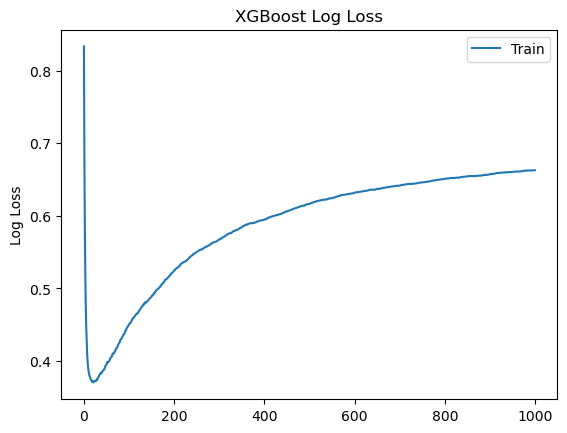

In [477]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
if 'validation_1' in results:
	ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

In [478]:
# plot classification report
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

           0       0.90      0.93      0.92       849
           1       0.69      0.24      0.36        37
           2       0.81      0.80      0.80       366

    accuracy                           0.87      1252
   macro avg       0.80      0.66      0.69      1252
weighted avg       0.87      0.87      0.87      1252



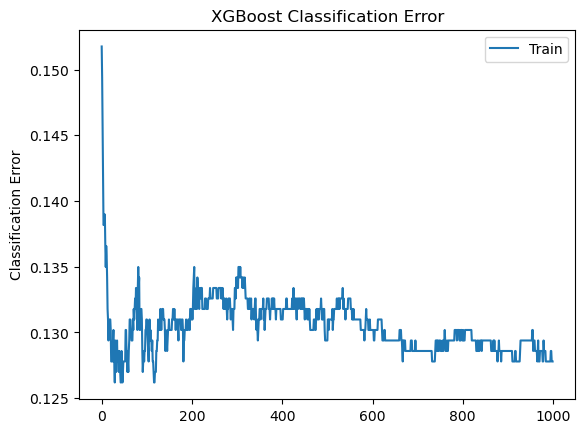

In [479]:
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
if 'validation_1' in results:
    ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()



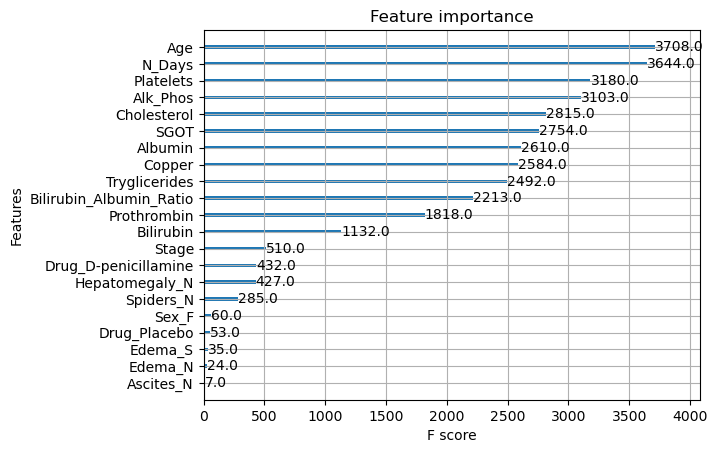

In [480]:

plot_importance(model) 
plt.show()

In [481]:
# Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
#        'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
#        'Stage', 'Drug_C', 'Drug_D-penicillamine', 'Drug_Drug', 'Drug_Placebo',
#        'Sex_F', 'Sex_M', 'Ascites_N', 'Ascites_Y', 'Hepatomegaly_N',
#        'Hepatomegaly_Y', 'Spiders_N', 'Spiders_Y', '
       
       
       
#        Edema_N', 'Edema_S',
#        'Edema_Y'],
#       dtype='object')

In [482]:
# import pickle
# pickle.dump(model, open("pima.pickle.dat", "wb")) 
# print("Saved model to: pima.pickle.dat")

# loaded_model = pickle.load(open("pima.pickle.dat", "rb")) 
# print("Loaded model from: pima.pickle.dat")